# Hands on Surprise library to build recommendation system

- This notebook gives a basic glimps of how we can create recommendation system using surprise library.
I will try to elaborate each steps and will include the learning resources to understand the algorithm that we are going to use.

- The "Surprise" library is a Python library designed for building and analyzing recommender systems. It's specifically focused on collaborative filtering, which is a technique used in recommendation systems to make automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating).

- The Surprise library provides a range of algorithms and tools to make it easier to work with recommendation systems. It supports both explicit and implicit feedback data and offers various collaborative filtering algorithms such as Singular Value Decomposition (SVD), K-Nearest Neighbors (KNN), and more. The library also provides tools for evaluating and comparing the performance of different recommendation algorithms.

# Dataset

We will be using movielens dataset.

Dataset URL : https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

In [2]:
# we can directly import dataset from surprise library
from surprise import Dataset

dataset = Dataset.load_builtin('ml-100k')
dataset

Dataset ml-100k could not be found. Do you want to download it? [Y/n] n
Ok then, I'm out!


SystemExit: 

/home/suman/anaconda3/envs/365ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


But for now we will be downloading it from kaggle and will do some EDA.

## EDA

In [231]:
import pandas as pd
import os

In [232]:
# checking path
!ls ../dataset/movieLens-sm

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


So we have 4 separate csv files, namely links, movies, ratings, and tags. Let's check out each files.

In [233]:
BASE_PATH = "../dataset/movieLens-sm/"
RATING_PATH = os.path.join(BASE_PATH, "ratings.csv")
MOVIE_PATH = os.path.join(BASE_PATH, "movies.csv")
LINKS_PATH = os.path.join(BASE_PATH, "links.csv")
TAGS_PATH = os.path.join(BASE_PATH, "tags.csv")

In [234]:
# read links.csv
links_df = pd.read_csv(LINKS_PATH)
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


As you can see, links.csv file contains corresponding movie_id in IMDB and TMDB.

- movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

- imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

- tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.


In [235]:
# read tags.csv
tags_df = pd.read_csv(TAGS_PATH)
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [236]:
# reading ratings.csv
ratings_df = pd.read_csv(RATING_PATH)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [237]:
ratings_df[ratings_df["movieId"]==2851]

,userId,movieId,rating,timestamp
282,3,2851,5.0,1306463925
31391,217,2851,3.0,955942393
42665,288,2851,2.0,1020369199
72810,469,2851,3.0,965335989


- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

**Note: This is the data we are going to use to build collaborative recommendation system. This gives information about users preference for each movies.**

In [238]:
# reading movies.cvs
movies_df = pd.read_csv(MOVIE_PATH)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [239]:
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [240]:
movies_df[movies_df["movieId"]==2851]

,movieId,title,genres
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller


In [241]:
movies_df.loc[2141]

movieId                         2851
title                Saturn 3 (1980)
genres     Adventure|Sci-Fi|Thriller
Name: 2141, dtype: object

- This file contains the information about movies title and genres of movie associated with the given movieId.
- Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

In [242]:
print("Total movies : ", len(movies_df))
print("Total ratings: ", len(ratings_df))
print("Total users: ", len(ratings_df["userId"].unique()))

Total movies :  9742
Total ratings:  100836
Total users:  610


So we have 9742 total movies in the corpus and there are in total 100K ratings given by 610 users.

In [243]:
# let's delete tags and links dataframe to free up some memory space
# since we don't need it for training recommendation
del tags_df
del links_df

# Data preprocessing

Surprise library creates internal IDS,
   - **Internal IDs:** These are the numeric IDs assigned by Surprise to users and items after the data is loaded into a Dataset object. These internal IDs are used internally by Surprise to index and manipulate the data. When you use these internal IDs, you typically work with Surprise-specific objects like Trainset and algorithms.

  - **Raw IDs:** These are the original IDs from your dataset, which could be strings, integers, or any other data type used to identify users and items in your actual data source.
  
To distinguish between the intern IDs and raw IDs, let's make some modification in our dataset.

In [244]:
# let's change moviesId from '<int>' to 'm_<int>' and similary userId from '<int>' to 'u_<int>'
movies_df['movieId'] = movies_df['movieId'].apply(lambda x: 'm_' + str(x))
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x: 'm_' + str(x))
ratings_df['userId'] = ratings_df['userId'].apply(lambda x: 'u_' + str(x))

In [245]:
movies_df.head()

,movieId,title,genres
0,m_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m_2,Jumanji (1995),Adventure|Children|Fantasy
2,m_3,Grumpier Old Men (1995),Comedy|Romance
3,m_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m_5,Father of the Bride Part II (1995),Comedy


In [266]:
movies_df[movies_df["title"] == "Saturn 3 (1980)"]

,movieId,title,genres
2141,m_2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,m_168358,Saturn 3 (1980),Sci-Fi|Thriller


In [246]:
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,u_610,m_166534,4.0,1493848402
100832,u_610,m_168248,5.0,1493850091
100833,u_610,m_168250,5.0,1494273047
100834,u_610,m_168252,5.0,1493846352
100835,u_610,m_170875,3.0,1493846415


# Data Loader

We have dataset in pandas dataframe, now to use surprise library built-in algorithms we have to convert it into Dataset object.

In [247]:
from surprise import Dataset, Reader

The **Reader** class in the Surprise library is used to specify how to read and parse your raw data into the **Dataset** object. It provides parameters that allow you to customize the way the data is formatted and loaded.

- **line_format:** This parameter defines the format of each line in your raw data file. It specifies the order of the data fields present in each line. For example, the line format is set to "user item rating timestamp", which means that each line in the data file should contain four fields: user ID, item ID, rating, and timestamp. other possible values "user item rating", "user item rating timestamp", "item user rating", "item rating user", "user rating item timestamp".

- **sep:** This parameter specifies the delimiter used to separate the fields in each line of your data file. In your example, it's set to ",", which means that the fields in each line are separated by commas.

- **skip_lines:** This parameter indicates the number of lines at the beginning of your data file to skip before starting to read the actual data. In your example, it's set to 1, which means that the first line (likely a header row) will be skipped, and the reading will start from the second line.

In [248]:
# let's create a reader object which we need to use for building Dataset object
# reader  = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)
reader  = Reader()

In [249]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,u_1,m_1,4.0,964982703
1,u_1,m_3,4.0,964981247
2,u_1,m_6,4.0,964982224
3,u_1,m_47,5.0,964983815
4,u_1,m_50,5.0,964982931


In [250]:
# creating a Dataset object
# It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order.
ratings_dataset =  Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader=reader)

In [251]:
ratings_dataset

Let's create a mapper that maps movie's name to the id.

In [252]:
movie_name_to_id = {row.title: row.movieId for row in movie_df.itertuples()}

In [253]:
list(movie_name_to_id.items())[:10]

[('Toy Story (1995)', 'm_1'),
 ('Jumanji (1995)', 'm_2'),
 ('Grumpier Old Men (1995)', 'm_3'),
 ('Waiting to Exhale (1995)', 'm_4'),
 ('Father of the Bride Part II (1995)', 'm_5'),
 ('Heat (1995)', 'm_6'),
 ('Sabrina (1995)', 'm_7'),
 ('Tom and Huck (1995)', 'm_8'),
 ('Sudden Death (1995)', 'm_9'),
 ('GoldenEye (1995)', 'm_10')]

Similarly, let's create a mapper that mapes movies' id to the name.

In [254]:
movie_id_to_name = {value: key for key, value in movie_name_to_id.items()}

In [255]:
list(movie_id_to_name.items())[:10]

[('m_1', 'Toy Story (1995)'),
 ('m_2', 'Jumanji (1995)'),
 ('m_3', 'Grumpier Old Men (1995)'),
 ('m_4', 'Waiting to Exhale (1995)'),
 ('m_5', 'Father of the Bride Part II (1995)'),
 ('m_6', 'Heat (1995)'),
 ('m_7', 'Sabrina (1995)'),
 ('m_8', 'Tom and Huck (1995)'),
 ('m_9', 'Sudden Death (1995)'),
 ('m_10', 'GoldenEye (1995)')]

In [264]:
movie_id_to_name["2851"]

KeyError: '2851'

## Helper functions
Let's create some helpers function

In [256]:
def get_user_ratings(user_id, return_dataframe=False):
    """
    Retrieve movie ratings for a specific user.

    Parameters:
        user_id (int): The ID of the user for whom to retrieve ratings.
        return_dataframe (bool, optional): If True, returns the ratings as a DataFrame. 
            If False (default), returns the ratings as a list of lists.

    Returns:
        list or DataFrame: Depending on the value of return_dataframe, returns either a list of
        lists containing movie ID and rating pairs, or a DataFrame containing the same information.
    """
    encoded_user_id = f"u_{user_id}"
    if not return_dataframe:
        return list(ratings_df[ratings_df["userId"] == encoded_user_id][["movieId", "rating"]].values.tolist())
    return ratings_df[ratings_df["userId"] == encoded_user_id][["movieId", "rating"]] 

In [257]:
get_user_ratings(1, True)

,movieId,rating
0,m_1,4.0
1,m_3,4.0
2,m_6,4.0
3,m_47,5.0
4,m_50,5.0
...,...,...
227,m_3744,4.0
228,m_3793,5.0
229,m_3809,4.0
230,m_4006,4.0


In [258]:
def get_movie_name(movie_id):
    encoded_movie_id = f"m_{movie_id}"
    return movie_id_to_name[encoded_movie_id]

def get_movie_id(movie_name):
    return movie_name_to_id[movie_name]

In [259]:
get_movie_name(5060)

'M*A*S*H (a.k.a. MASH) (1970)'

In [260]:
get_movie_id("Saturn 3 (1980)")

'm_168358'

## Train/Test Split

Now, we have to split the dataset into train/test set, alternatively we can perform cross-validation also. For now, let's stick to the train/test split

In [140]:
from surprise.model_selection import train_test_split

In [141]:
train_set, test_set = train_test_split(ratings_dataset, test_size=0.2, random_state=1)

- `trainset:` This is a Trainset object which contains the training data that you'll use to train your recommendation model.
- `testset:` This is a list of tuples, each representing a user-item interaction in the testing set. Each tuple has the format (user_id, item_id, rating).

In [142]:
print("size of ratings in train set: ", train_set.n_ratings)
print("size of users in train set: ", train_set.n_users)
print("size of movies in train set: ", train_set.n_items)
print("size of test set: ", len(test_set))

size of ratings in train set:  80668
size of users in train set:  610
size of movies in train set:  8983
size of test set:  20168


In [143]:
test_set[:5]

[('u_469', 'm_2243', 4.0),
 ('u_187', 'm_49932', 4.0),
 ('u_399', 'm_589', 2.5),
 ('u_610', 'm_1394', 5.0),
 ('u_288', 'm_8965', 3.5)]

# Algorithm Setup

- For this notebook, we are going to use only SVD (Singular Value Decomposition) algorithm to build a collaboration based recommendation system. Leter we will be working on building recommendation engine framework, where we can evaluate multiple algorithms. 
- If you are not familary with linear algebra and how SVD works, you can checkout the given links to get the intuition about how SVD works.
    - Linear algebra by khan academy: https://www.youtube.com/watch?v=aKhhYguY0DQ&list=PLFD0EB975BA0CC1E0
    - Essence of linear algebra: https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab
    - Metrix visualization: https://www.youtube.com/watch?v=UyAfmAZU_WI
    - SVD and recommendation system: https://www.youtube.com/watch?v=rFemvJgXY7E
    - Dimensionality Reduction with SVD: https://www.youtube.com/watch?v=UyAfmAZU_WI


In [147]:
from surprise import SVD

Singular Value Decomposition (SVD) is a powerful mathematical technique that has found applications in various fields, including recommendation systems. In the context of recommendation systems, SVD is often used for collaborative filtering, which is a technique that predicts a user's preferences or recommendations by leveraging the preferences of other users.

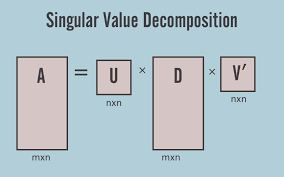

Here's how SVD can be applied to recommendation systems:

Singular Value Decomposition (SVD) can be employed in recommendation systems to make personalized recommendations based on user-item interactions. The process involves decomposing the user-item interaction matrix into three matrices that capture underlying patterns, and then using these matrices to predict missing values and generate recommendations. Here's a step-by-step explanation of how SVD works for recommendation systems:

1. **User-Item Interaction Matrix:** Consider a user-item interaction matrix where rows represent users, columns represent items, and the cells contain user ratings or interactions with items. However, this matrix is often sparse because users have not rated all items.

2. **SVD Decomposition:** SVD aims to factorize the user-item interaction matrix (A) into three matrices: U (user matrix), Σ (diagonal matrix of singular values), and V^T (item matrix transpose). Mathematically, this can be represented as A = UΣV^T. The dimensions of U and V^T are such that U has dimensions m x k (m = number of users, k = number of latent factors), Σ is a k x k diagonal matrix, and V^T has dimensions k x n (n = number of items).

3. **Dimensionality Reduction:** The key idea of SVD is to reduce the dimensionality of the original matrix by capturing latent factors. These latent factors represent hidden patterns that contribute to user preferences. The columns of U and V^T correspond to these latent factors. By selecting a smaller value for k (the rank of the factorization), you effectively reduce the dimensions of U and V^T matrices. This is important for dealing with sparsity and noise in the original user-item matrix.

4. **Matrix Reconstruction:** Once you have the U, Σ, and V^T matrices, you can reconstruct the original user-item interaction matrix by multiplying them: A_reconstructed = UΣV^T. The reconstructed matrix represents predicted ratings for all users and items.

5. **Prediction and Recommendation:** To make recommendations for a specific user, you focus on the row of the user in the reconstructed matrix. The missing values (items the user hasn't interacted with) in this row are filled with the predicted ratings. Higher predicted ratings indicate potential interest, and you can sort these predicted ratings to generate a list of recommended items for the user.

6. **Cold Start and New Data:** One challenge of SVD-based recommendation systems is the cold start problem, where new users or items have limited or no interactions. SVD struggles to provide recommendations for such cases, as it relies on historical interactions. In such scenarios, hybrid approaches that combine SVD with content-based recommendations or other techniques might be more effective.

7. **Regularization and Bias:** To improve the performance of SVD-based recommendation systems, regularization techniques can be applied to prevent overfitting. Additionally, bias terms can be incorporated to account for user and item biases, which can help capture nuances in user preferences and item popularity.

It's important to note that while SVD-based recommendation systems were popular in the past, more recent approaches like matrix factorization with neural networks and embeddings-based models have shown better performance due to their ability to capture complex patterns and handle large-scale data more effectively.

In [148]:
svd_model = SVD(random_state=10)

In [149]:
# training our SVD_model
svd_model.fit(train_set)

let's make predictions on testset

In [150]:
predictions = svd_model.test(test_set)

In [151]:
predictions[:10]

[Prediction(uid='u_469', iid='m_2243', r_ui=4.0, est=3.5778806340563234, details={'was_impossible': False}),
 Prediction(uid='u_187', iid='m_49932', r_ui=4.0, est=3.6264424117130942, details={'was_impossible': False}),
 Prediction(uid='u_399', iid='m_589', r_ui=2.5, est=4.1965886466453055, details={'was_impossible': False}),
 Prediction(uid='u_610', iid='m_1394', r_ui=5.0, est=4.190842986448906, details={'was_impossible': False}),
 Prediction(uid='u_288', iid='m_8965', r_ui=3.5, est=2.609570328648279, details={'was_impossible': False}),
 Prediction(uid='u_182', iid='m_6890', r_ui=4.5, est=3.664976335949917, details={'was_impossible': False}),
 Prediction(uid='u_357', iid='m_3481', r_ui=3.0, est=3.941798959205346, details={'was_impossible': False}),
 Prediction(uid='u_202', iid='m_2628', r_ui=4.0, est=3.133616813669155, details={'was_impossible': False}),
 Prediction(uid='u_600', iid='m_1348', r_ui=2.5, est=3.2628024666883624, details={'was_impossible': False}),
 Prediction(uid='u_249',

Let's break down the different components of this prediction `Prediction(uid='469', iid='2243', r_ui=4.0, est=3.5778806340563234, details={'was_impossible': False})`:

- **uid:** This is the user ID for which the prediction was made. In this case, the user ID is '469'.

- **iid:** This is the item ID for which the prediction was made. In this case, the item ID is '2243'.

- **r_ui:** This is the actual rating that the user with ID '469' gave to the item with ID '2243'. In this prediction result, the actual rating is 4.0.

- **est:** This is the estimated or predicted rating that the recommendation algorithm provided for the user-item combination ('469', '2243'). The estimated rating is approximately 3.5779.

- **details:** This is a dictionary that provides additional information about the prediction. In this case, the key **'was_impossible'** is `False`, indicating that the prediction was possible and not flagged as impossible by the algorithm. This is useful when dealing with cases where the algorithm couldn't provide a prediction due to certain conditions not being met.


## Evaluation

In [152]:
from surprise import accuracy

In [153]:
mae = accuracy.mae(predictions, verbose=False)
mae

0.6703919368150372

In [154]:
rmse = accuracy.rmse(predictions, verbose=False)
rmse

0.874705732433194

## Predictions

In [155]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [156]:
movie_id_user_2 = list(rating_df[rating_df["userId"]==2]["movieId"].unique())
print("Movies that user_2 has rated: ", movie_id_user_2)

Movies that user_2 has rated:  [318, 333, 1704, 3578, 6874, 8798, 46970, 48516, 58559, 60756, 68157, 71535, 74458, 77455, 79132, 80489, 80906, 86345, 89774, 91529, 91658, 99114, 106782, 109487, 112552, 114060, 115713, 122882, 131724]


In [157]:
user_id = '1'
movie_id = '1'
predicted_rating = svd_model.predict(user_id, movie_id)
print("predicted ratings", predicted_rating.est)

predicted ratings 3.5038119204641247


In [158]:
# let's check the prediction for user 2 for the movie that he haven't rated yet
user_id = '2'
movie_id = '50'
predicted_rating = svd_model.predict(user_id, movie_id) #it supposed to predict 5
predicted_rating

Prediction(uid='2', iid='50', r_ui=None, est=3.5038119204641247, details={'was_impossible': False})

Here you can see r_ui is None.

# recommending top N movies

In [159]:
from collections import defaultdict

In [160]:
trainset = rating_dataset.build_full_trainset()

In [178]:
def get_top_n(data, user_id, n=10, minimum_rating=3.0):
    encoded_user_id = f"u_{user_id}"
    # get inner uid of the raw user_id
    inner_uid = data.to_inner_uid(encoded_user_id)
    # get the list of movie_id that user has rated
    rated_movie_id = [movie[0] for movie in data.ur[inner_uid]]
    
    # movies not rated by the user
    inner_movieid_not_rated = [movie_id for movie_id in data.all_items() if not movie_id in rated_movie_id]
    
    # get estimation for these movies
    predictions = [svd_model.predict(user_id, data.to_raw_iid(movie_id)) for movie_id in inner_movieid_not_rated]
    
    # return top n
    top_n = []
    for user_id, movie_id, actual_rating, predicted_rating, _ in predictions:
        decoded_movie_id = movie_id.split("_")[1]
        top_n.append((movie_id, predicted_rating, get_movie_name(decoded_movie_id)))
    # sort the estimated movie ratings
    top_n.sort(key = lambda kv: kv[1], reverse=True)
    return top_n[:n]

In [179]:
get_top_n(trainset, '4')

KeyError: 'm_2851'

In [172]:
get_movie_name('2851')

KeyError: 'm_2851'